In [72]:
import pandas as pd
import numpy as np
import requests
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
import time
from nltk.tokenize import word_tokenize
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.pipeline import Pipeline

In this project, I will build a classification model that will predict whether a reddit post, with only the title and text content provided, is in the World of Warcraft (WoW) subreddit or the Final Fantasy XIV (FFXIV) subreddit.  
I am approaching the problem from the perspective of part of the marketing team at Square Enix, the publisher of FFXIV.  With this model, we may uncover language that our players use more frequently than those who enjoy our prime competitor, so we can better craft our marketing to appeal to our customers.

# Pushshift scraping!

The first thing we need is to use pushshift to grab our posts.  I built a function to grab 100 posts from every month from each subreddit, going back to the founding of the FFXIV subreddit (which, oddly enough, happens to be 10 years ago almost to the day!)

In [73]:
def posts_getter(subreddit):
    #using https://www.epochconverter.com/ I converted the current date 
    #and dates of the FFXI subreddit's founding (ffxiv is younger, so this way we'll have a more equal split)
    current_epoch = 1611872155
    founding_epoch = 1454019344
    one_month_in_seconds = 2628288
    url = 'https://api.pushshift.io/reddit/search/submission'
    posts = []
    #iterates, month by month, from the founding of the r/ffxiv to january 28, 2021, pulling 100 posts every month.
    #this spread of time helps ensure that there are no duplicate posts, and also gives us a very wide view of each subreddit
    #additionally, setting a timer to limit the strain on the websites
    time.sleep(15)
    for month in range(founding_epoch, current_epoch, one_month_in_seconds):
        res = requests.get(url, {'subreddit': subreddit, 'size': 100, 'before': month})
        try:
            data = res.json()
            posts.extend(data['data'])
        except:
            pass
        #for equity in post counts between the two subreddits, I stop them both once they exceed 2500.
        if len(posts) > 2500:
            break
    return posts
#gets the posts
ffxiv_posts = posts_getter('ffxiv')
wow_posts = posts_getter('wow')
#turns those posts into a dataframe
ffxiv_df = pd.DataFrame(ffxiv_posts)
wow_df = pd.DataFrame(wow_posts)
print('ffxiv shape is',ffxiv_df.shape)
print('wow shape is ',wow_df.shape)

ffxiv shape is (2600, 81)
wow shape is  (2600, 73)


We now have our two dataframes! Let's put them together!  I don't need to fret over differences in columns, since we only need three columns from them anyways.

In [74]:
df = pd.concat([ffxiv_df, wow_df], axis = 0)

Normally, I'd leave the below uncommented in order to save the dataframe.  However, I'm commenting it out to make sure I'm calling the same dataframe that I created on Saturday, January 30th.  This keeps my modeling consistent day to day.  If I were to take this into production, I would remove this comment (and a similar comment below that does the same thing once the dataset is clean.)

In [75]:
#df.to_csv('./datasets/concatenated_df.csv', index = False)

df = pd.read_csv('./datasets/concatenated_df.csv')

# Cleaning, tokenizing, and analyzing

Now, I'm turning my subreddit column into a numeric, and renaming it to reflect that.  I could have used get_dummies here as well, but decided to use this method as it makes certain that FFXIV is my positive value.  (This is merely a matter of taste:  I'm an avid FFXIV player.)

In [76]:
df['subreddit'].replace(['ffxiv','wow'],[1,0], inplace = True)
df.rename(columns = {'subreddit':'is_on_ffxiv'}, inplace = True)

Let's do some preliminary cleanings.  First, any null 'selftext' values will be the result of that post being something other than a self text post, such as an image, link, or video.  Thus, I'm replacing those nulls with 'notatextpost', with that string serving as an indicator, and something we can drop later once count vectorization is done.

In [77]:
df.loc[lambda df: df['selftext'].isna() == True] = df.loc[lambda df: df['selftext'].isna() == True].fillna('notatextpost')
print(df['selftext'].isna().sum())

0


Next, I separate the three columns I really need: my features and my target.

In [78]:
df = df[['selftext','title', 'is_on_ffxiv']]

In [79]:
df.isna().sum()

selftext       0
title          0
is_on_ffxiv    0
dtype: int64

In [80]:
df.shape

(5200, 3)

Looks good!  One more cleaning step:  dropping rows where the text was either deleted or removed:  We don't need to see what deleted posts have to say, and we also don't want to include any posts that were removed by a subreddit moderator, as that could lead to spam entering our dataset.

In [81]:
#dropping the rows where the post was removed, by a mod (removed) or the user (deleted).  Doesn't really offer us any good information, and could even give us spam posts that the mods removed.
df.drop(df.loc[lambda df: df['selftext'] == '[removed]'].index, inplace = True)
df.drop(df.loc[lambda df: df['selftext'] == '[deleted]'].index, inplace = True)

Next, in order to get my data ready to model, I use the Snowball Stemmer to get stems of every word in my text posts and my titles.  I chose Snowball Stemmer specifically because of it's built-in language support, it's aggressiveness, and the fact that I can tell it to ignore stop words, which results in a faster runtime.  Those stopwords will get dropped later by CountVectorizer, anyways. This will help save on computational expenses later on as well, since I'll have fewer features from my CountVectorizer for my models to handle.   

In [82]:
#first, tokenize both 'selftext' and 'title' in order to prep them for stemming
def identify_selftext_tokens(row):
    text = row['selftext']
    tokens = word_tokenize(text)
    token_words = [w for w in tokens if w.isalpha()]
    return token_words
def identify_title_tokens(row):
    text = row['title']
    tokens = word_tokenize(text)
    token_words = [w for w in tokens if w.isalpha()]
    return token_words
#apply the above functions
df['self_text_words'] = df.apply(identify_selftext_tokens, axis = 1)
df['title_words'] = df.apply(identify_title_tokens, axis = 1)
#apply the snowball stemmer, giving me the ultimate stemmed tokens I need.
df['stemmed_self_text'] = df['self_text_words'].apply(lambda x: [SnowballStemmer("english", ignore_stopwords=True).stem(y) for y in x])
df['stemmed_title'] = df['title_words'].apply(lambda x: [SnowballStemmer("english", ignore_stopwords=True).stem(y) for y in x])

While I'm at it, I also created columns for post length and title length.  This may be nothing, but it's a feature worth investigating.

In [83]:
df['self_text_len'] = df['selftext'].apply(lambda x: len(x.split()))
df['title_len'] = df['title'].apply(lambda x: len(x.split()))

Finally, I use the VADER Sentiment Intensity Analyser to analyze both my titles and my self text.

In [84]:
analyzer = SentimentIntensityAnalyzer()
#self text first
df['self_text_vader_neg'] = 0
df['self_text_vader_pos'] = 0
df['self_text_vader_neu'] = 0
df['self_text_vader_compound'] = 0
for i, q in enumerate(df.selftext.values):
    vs = analyzer.polarity_scores(q)
    df.iloc[i, -4] = vs['neg']
    df.iloc[i, -3] = vs['pos']
    df.iloc[i, -2] = vs['neu']
    df.iloc[i, -1] = vs['compound']
#now titles
df['title_vader_neg'] = 0
df['title_vader_pos'] = 0
df['title_vader_neu'] = 0
df['title_vader_compound'] = 0
for i, q in enumerate(df.title.values):
    vs = analyzer.polarity_scores(q)
    df.iloc[i, -4] = vs['neg']
    df.iloc[i, -3] = vs['pos']
    df.iloc[i, -2] = vs['neu']
    df.iloc[i, -1] = vs['compound']
#this code is copied over almost wholesale from the Sentiment Analysis lesson.

Now, once my stemming, SA, and lengths have all been taken care of, I get rid of the columns I don't need.

In [85]:
df.drop(columns = ['selftext','title','self_text_words','title_words'], inplace = True)

In [86]:
#one last check to make sure our dataframe looks how we want it to
df.head()

,is_on_ffxiv,stemmed_self_text,stemmed_title,self_text_len,title_len,self_text_vader_neg,self_text_vader_pos,self_text_vader_neu,self_text_vader_compound,title_vader_neg,title_vader_pos,title_vader_neu,title_vader_compound
0,1,[notatextpost],"[post, your, favourit, screenshot]",1,4,0.0,0.0,1.0,0.0,0.000,0.000,1.000,0.0000
3,1,[notatextpost],"[have, drawn, anyth, in, like, a, decad, pick,...",1,21,0.0,0.0,1.0,0.0,0.066,0.207,0.727,0.5431
4,1,[notatextpost],"[what, are, the, chanc, the, fate, of, this, n...",1,13,0.0,0.0,1.0,0.0,0.000,0.130,0.870,0.2023
5,1,"[so, a, few, week, ago, there, was, a, new, su...","[ffxiv, survey, realm, pop, etc, look, for]",49,6,0.0,0.0,1.0,0.0,0.000,0.000,1.000,0.0000
6,1,[notatextpost],"[drew, my, pld, and, lalafel, smn]",1,7,0.0,0.0,1.0,0.0,0.000,0.000,1.000,0.0000


It's clean, stemmed, analyzed, and I've got some extra features to work with.  Let's save it to a csv, for consistency.

In [87]:
#df.to_csv('./datasets/stemmed_and_cleaned_df.csv', index = False)

df = pd.read_csv('./datasets/stemmed_and_cleaned_df.csv')

## EDA Visualizations & Feature Engineering

Let's begin the EDA with some basic summary statistics.  We've only got two numeric columns, so let's see what they have to say.

In [88]:
df['self_text_len'].describe()

count    4176.000000
mean       62.377874
std       119.733272
min         1.000000
25%         1.000000
50%        30.000000
75%        76.000000
max      2448.000000
Name: self_text_len, dtype: float64

A high average for post length, and a very high standard deviation.  I suspect that maximum of 4000 is pulling the mean and std higher than they ought to be.

In [89]:
df['title_len'].describe()

count    4176.000000
mean        8.367098
std         5.356964
min         1.000000
25%         5.000000
50%         7.000000
75%        11.000000
max        59.000000
Name: title_len, dtype: float64

While the standard deviation isn't as out of proportion as it is in self-text, there remains a significant outlier in the titles.  Hopefully, I'll see what that's about by examining the distributions.

First, let's see the distributions of our self text lengths and our title lengths.  I'll do one table that includes both subs, and then one table for each of them.

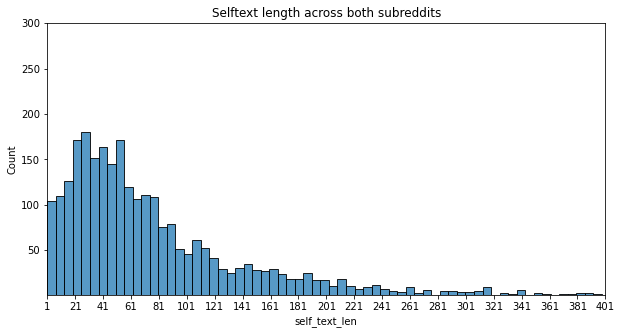

In [90]:
plt.figure(figsize=(10,5))
plt.xlim(1, 400)
plt.ylim(1,300)
plt.xticks(range(1,420,20))
#excludes all 'notatextpost'
plt.title('Selftext length across both subreddits')
sns.histplot(df.loc[df['stemmed_self_text'] != "['notatextpost']"]['self_text_len'], bins = 400);

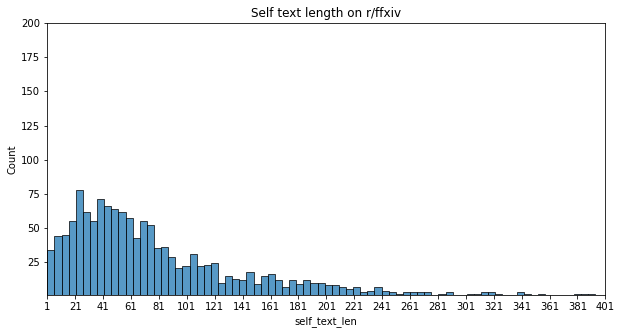

In [91]:
plt.figure(figsize = (10,5))
plt.xlim(1, 400)
plt.ylim(1,200)
plt.xticks(range(1,420,20))
#exclude all 'notatextpost' and 'deleted' values
plt.title('Self text length on r/ffxiv')
sns.histplot(df.loc[df['stemmed_self_text'] != "['notatextpost']"].loc[df['is_on_ffxiv'] == 1]['self_text_len'], bins = 400);

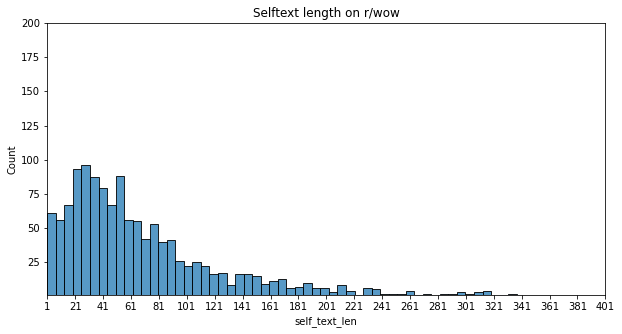

In [92]:
plt.figure(figsize = (10,5))
plt.xlim(1, 400)
plt.ylim(1,200)
plt.xticks(range(1,420,20))
#exclude all 'notatextpost' and 'deleted' values
plt.title('Selftext length on r/wow')
sns.histplot(df.loc[df['stemmed_self_text'] != "['notatextpost']"].loc[df['is_on_ffxiv'] == 0]['self_text_len'], bins = 400);

Many posts with just less than ten words here.  Even after removing deleted, mod-removed, and non-text posts, there's still very many.  A surprising statistic, and it is consistent across both subreddits.   Beyond that, though, the distributions are very similar to eachother.

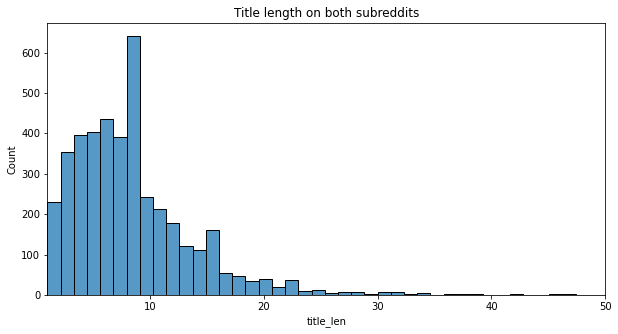

In [93]:
plt.figure(figsize = (10,5))
plt.xlim(1, 50)
plt.title('Title length on both subreddits')
sns.histplot(df['title_len'], bins = 50);

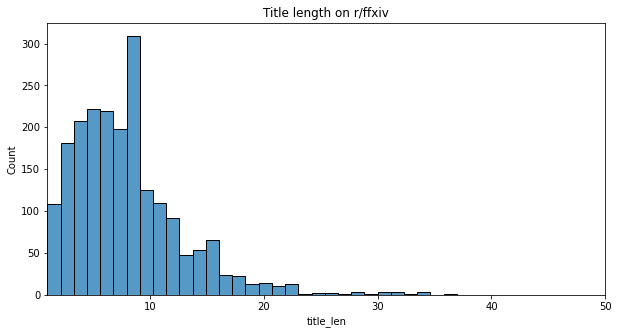

In [94]:
plt.figure(figsize = (10,5))
plt.xlim(1, 50)
plt.title('Title length on r/ffxiv')
sns.histplot(df.loc[df['is_on_ffxiv'] == 1]['title_len'], bins = 50);

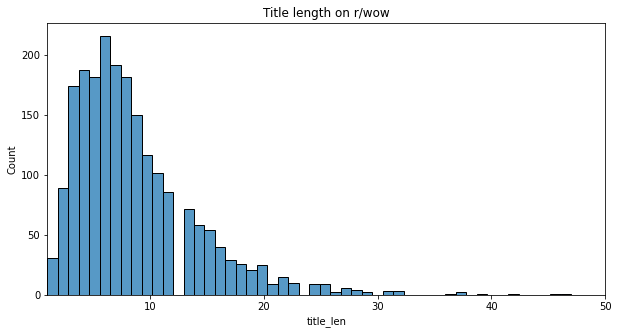

In [95]:
plt.figure(figsize = (10,5))
plt.xlim(1, 50)
plt.title('Title length on r/wow')
sns.histplot(df.loc[df['is_on_ffxiv'] == 0]['title_len'], bins = 50);

A very interesting difference in distributions here.  Perhaps this feature can hold some real value for our model!

Next, I'll examine some box plots to get a better look at those outliers.

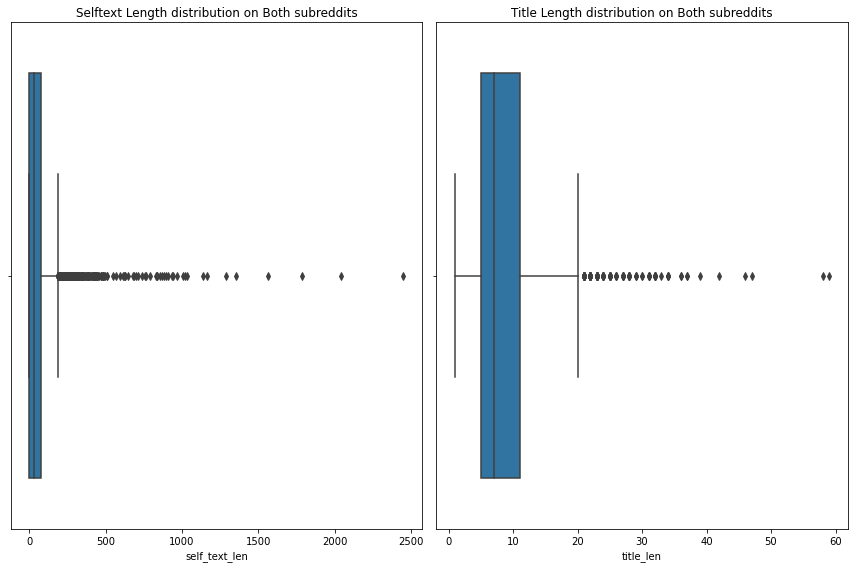

In [96]:
plt.subplot(121)
#plt.figure(figsize = (10,5))
plt.title('Selftext Length distribution on Both subreddits')
sns.boxplot(x= df['self_text_len'])
plt.subplot(122)
plt.title('Title Length distribution on Both subreddits')
sns.boxplot(x= df['title_len'])
plt.tight_layout(rect=(8,8,10,10))

Tons of outliers here. I anticipate that to stay consistent.

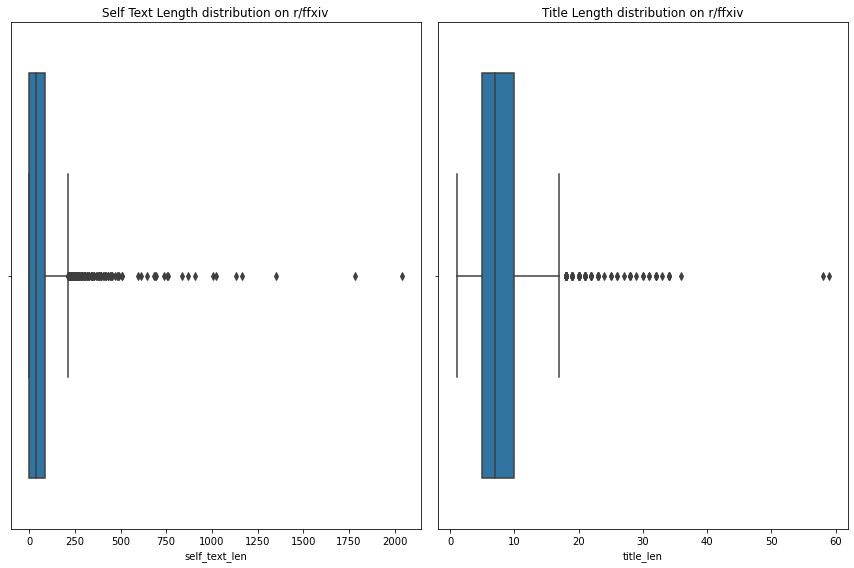

In [97]:
plt.subplot(121)
plt.title('Self Text Length distribution on r/ffxiv')
sns.boxplot(x= df.loc[df['is_on_ffxiv'] == 1]['self_text_len'])
plt.subplot(122)
plt.title('Title Length distribution on r/ffxiv')
sns.boxplot(x= df.loc[df['is_on_ffxiv'] == 1]['title_len'])
plt.tight_layout(rect=(8,8,10,10))

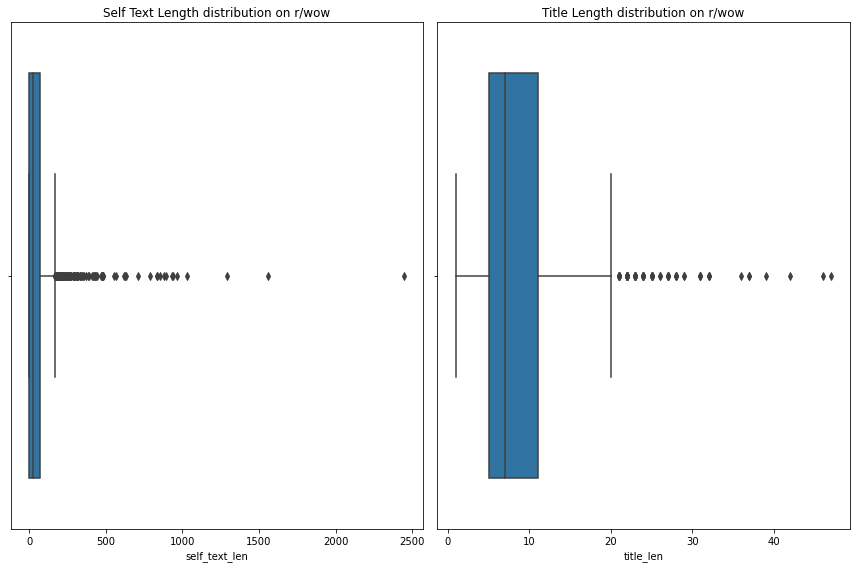

In [98]:
plt.subplot(121)
plt.title('Self Text Length distribution on r/wow')
sns.boxplot(x= df.loc[df['is_on_ffxiv'] == 0]['self_text_len'])
plt.subplot(122)
plt.title('Title Length distribution on r/wow')
sns.boxplot(x= df.loc[df['is_on_ffxiv'] == 0]['title_len'])
plt.tight_layout(rect=(8,8,10,10))

#look at correlations too!
With these boxplots, we can better see the number of outliers in each distribution, and this data only further reinforces my plan to drop the length and title columns from our features.  The only place where a distinct difference is seen is in Title length, and so I think that'll be the only column I keep around.

In order to examine those outliers,though, let's see our longest titles and see if they're spam or real posts to consider.

In [99]:
df.sort_values(by = 'title_len', ascending= False)['stemmed_title'][528]

"['is', 'there', 'a', 'list', 'of', 'stuff', 'that', 'unlock', 'after', 'level', 'anywher', 'i', 'know', 'most', 'peopl', 'say', 'to', 'do', 'msq', 'in', 'hw', 'to', 'get', 'to', 'but', 'just', 'wonder', 'if', 'there', 'was', 'any', 'rare', 'weapon', 'etc', 'that', 'you', 'can', 'start', 'work', 'toward', 'from', 'level', 'alreadi', 'gone', 'to', 'marketboard', 'and', 'put', 'on', 'gear', 'to', 'make', 'myself', 'ilvl', 'overal']"

In [100]:
df.sort_values(by = 'title_len', ascending= False)['stemmed_title'][1352]

"['final', 'got', 'my', 'zeta', 'this', 'relic', 'is', 'import', 'to', 'me', 'sinc', 'back', 'then', 'when', 'it', 'was', 'first', 'teas', 'in', 'the', 'develop', 'blog', 'i', 'was', 'away', 'from', 'the', 'game', 'but', 'when', 'i', 'saw', 'it', 'i', 'got', 'back', 'in', 'and', 'have', 'look', 'back', 'know', 'i', 'put', 'hard', 'work', 'into', 'this', 'even', 'with', 'all', 'the', 'nerf', 'i', 'proud', 'of', 'this', 'moment']"

Well, the top 2 longest titles look like honest posts, if a little against best posting practices on reddit.  I'll be leaving them in:  I don't want to exclude real data just because it's outside the norm.

Next, I want to examine the distributions of all my Vader scores, both on the whole and on each subreddit.

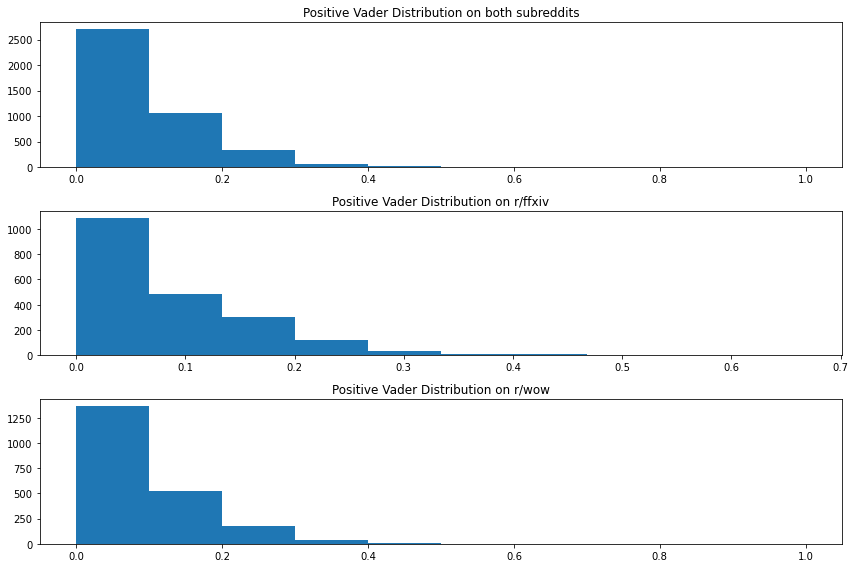

In [101]:
plt.subplot(311)
plt.title('Positive Vader Distribution on both subreddits')
plt.hist(df['self_text_vader_pos']);
plt.subplot(312)
plt.title('Positive Vader Distribution on r/ffxiv')
plt.hist(df.loc[df['is_on_ffxiv'] == 1]['self_text_vader_pos'])
plt.subplot(313)
plt.title('Positive Vader Distribution on r/wow')
plt.hist(df.loc[df['is_on_ffxiv'] == 0]['self_text_vader_pos'])
plt.tight_layout(rect = (2,2,4,4));

Much like before, very very similar distributions.

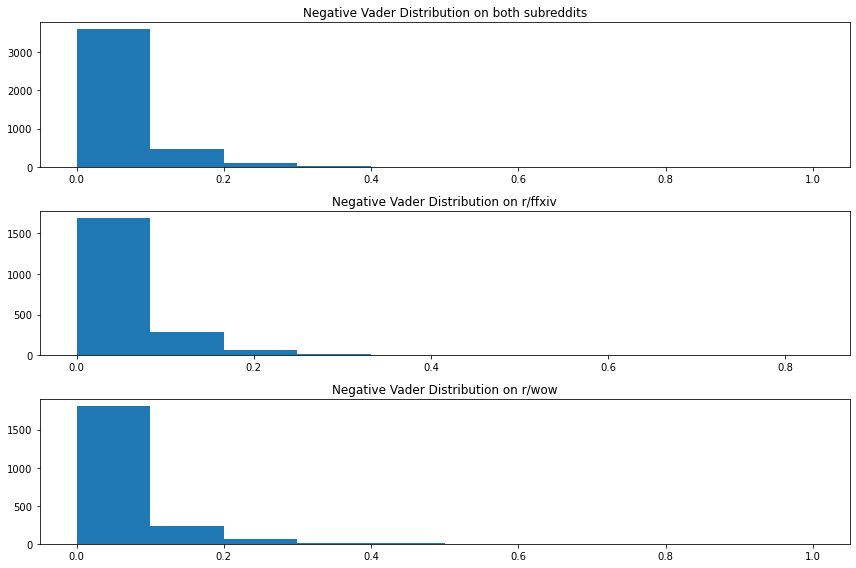

In [102]:
plt.subplot(311)
plt.title('Negative Vader Distribution on both subreddits')
plt.hist(df['self_text_vader_neg']);
plt.subplot(312)
plt.title('Negative Vader Distribution on r/ffxiv')
plt.hist(df.loc[df['is_on_ffxiv'] == 1]['self_text_vader_neg'])
plt.subplot(313)
plt.title('Negative Vader Distribution on r/wow')
plt.hist(df.loc[df['is_on_ffxiv'] == 0]['self_text_vader_neg'])
plt.tight_layout(rect = (2,2,4,4));

More of the same.

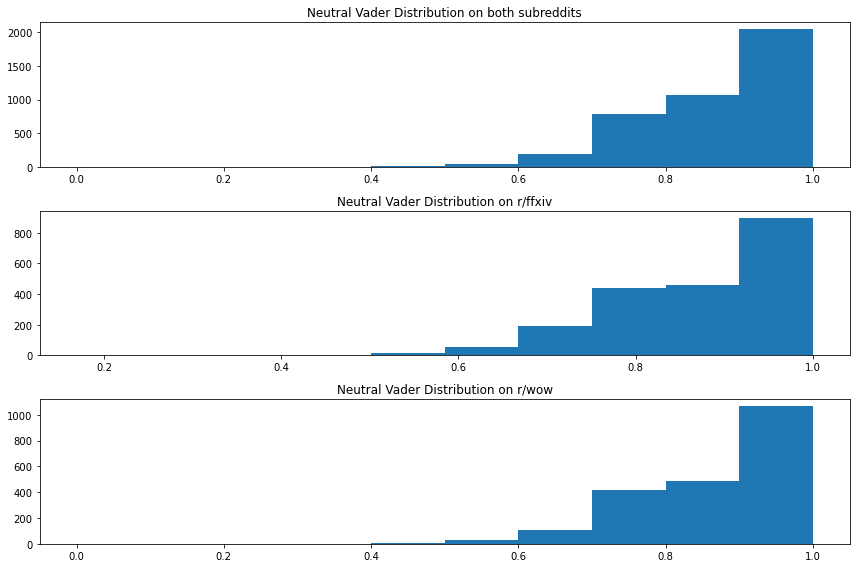

In [103]:
plt.subplot(311)
plt.title('Neutral Vader Distribution on both subreddits')
plt.hist(df['self_text_vader_neu']);
plt.subplot(312)
plt.title('Neutral Vader Distribution on r/ffxiv')
plt.hist(df.loc[df['is_on_ffxiv'] == 1]['self_text_vader_neu'])
plt.subplot(313)
plt.title('Neutral Vader Distribution on r/wow')
plt.hist(df.loc[df['is_on_ffxiv'] == 0]['self_text_vader_neu'])
plt.tight_layout(rect = (2,2,4,4));

And again, more of the same, but traveling in the other direction.

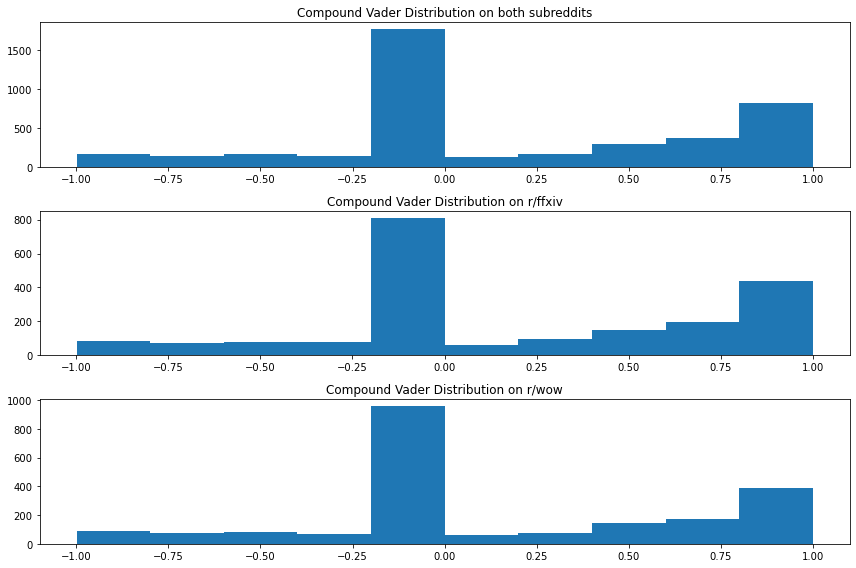

In [104]:
plt.subplot(311)
plt.title('Compound Vader Distribution on both subreddits')
plt.hist(df['self_text_vader_compound']);
plt.subplot(312)
plt.title('Compound Vader Distribution on r/ffxiv')
plt.hist(df.loc[df['is_on_ffxiv'] == 1]['self_text_vader_compound'])
plt.subplot(313)
plt.title('Compound Vader Distribution on r/wow')
plt.hist(df.loc[df['is_on_ffxiv'] == 0]['self_text_vader_compound'])
plt.tight_layout(rect = (2,2,4,4));

More of the same.  I'm going to drop these features.

Next, let's examine those distributions in our titles.

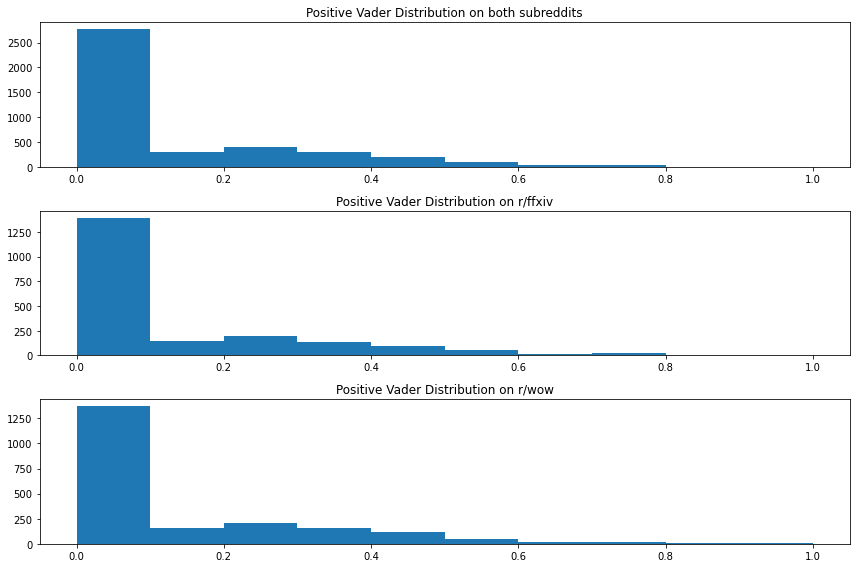

In [105]:
plt.subplot(311)
plt.title('Positive Vader Distribution on both subreddits')
plt.hist(df['title_vader_pos']);
plt.subplot(312)
plt.title('Positive Vader Distribution on r/ffxiv')
plt.hist(df.loc[df['is_on_ffxiv'] == 1]['title_vader_pos'])
plt.subplot(313)
plt.title('Positive Vader Distribution on r/wow')
plt.hist(df.loc[df['is_on_ffxiv'] == 0]['title_vader_pos'])
plt.tight_layout(rect = (2,2,4,4));

Same distributions again.

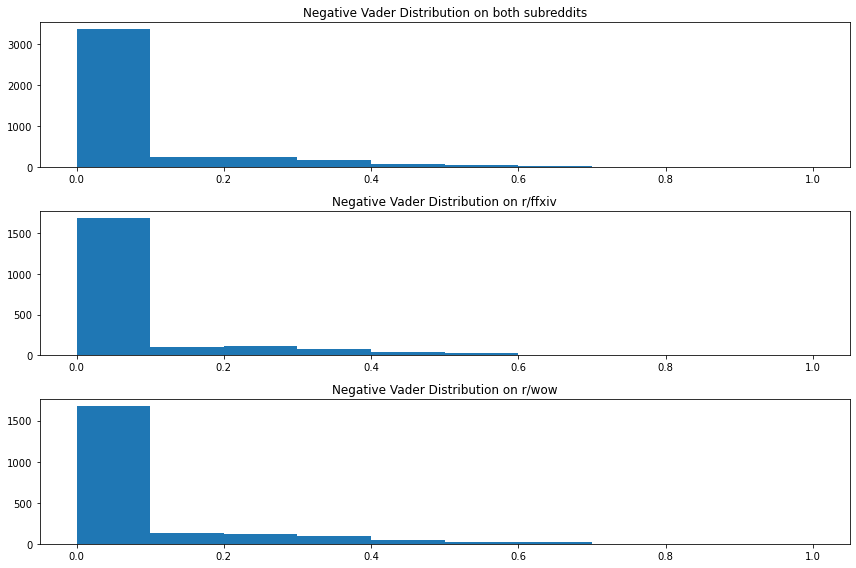

In [106]:
plt.subplot(311)
plt.title('Negative Vader Distribution on both subreddits')
plt.hist(df['title_vader_neg']);
plt.subplot(312)
plt.title('Negative Vader Distribution on r/ffxiv')
plt.hist(df.loc[df['is_on_ffxiv'] == 1]['title_vader_neg'])
plt.subplot(313)
plt.title('Negative Vader Distribution on r/wow')
plt.hist(df.loc[df['is_on_ffxiv'] == 0]['title_vader_neg'])
plt.tight_layout(rect = (2,2,4,4));

And again.

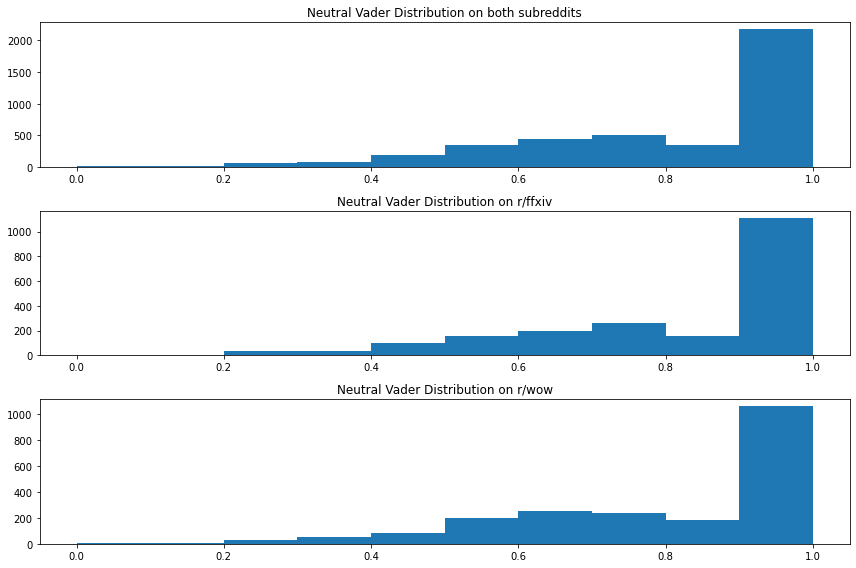

In [107]:
plt.subplot(311)
plt.title('Neutral Vader Distribution on both subreddits')
plt.hist(df['title_vader_neu']);
plt.subplot(312)
plt.title('Neutral Vader Distribution on r/ffxiv')
plt.hist(df.loc[df['is_on_ffxiv'] == 1]['title_vader_neu'])
plt.subplot(313)
plt.title('Neutral Vader Distribution on r/wow')
plt.hist(df.loc[df['is_on_ffxiv'] == 0]['title_vader_neu'])
plt.tight_layout(rect = (2,2,4,4));

And again.

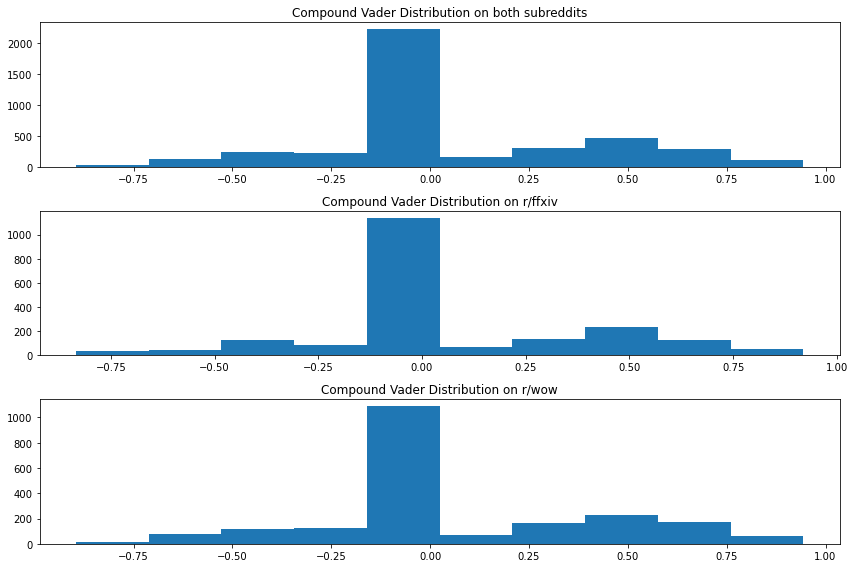

In [108]:
plt.subplot(311)
plt.title('Compound Vader Distribution on both subreddits')
plt.hist(df['title_vader_compound']);
plt.subplot(312)
plt.title('Compound Vader Distribution on r/ffxiv')
plt.hist(df.loc[df['is_on_ffxiv'] == 1]['title_vader_compound'])
plt.subplot(313)
plt.title('Compound Vader Distribution on r/wow')
plt.hist(df.loc[df['is_on_ffxiv'] == 0]['title_vader_compound'])
plt.tight_layout(rect = (2,2,4,4));

Every one of these distributions is almost identical.  It appears that none of the vader data will make our model more effective, since none if it is indicative towards one class or the other.  I'll be dropping all these columns except for the Title length, as there may still be some value in that feature.

In [109]:
df.drop(columns = [
    'self_text_len',
    'self_text_vader_pos',
    'self_text_vader_neu',
    'self_text_vader_neg',
    'self_text_vader_compound',
    'title_vader_pos',
    'title_vader_neg',
    'title_vader_neu',
    'title_vader_compound'], 
    inplace = True)

## Vectorizing and Modeling

My data is clean, I've pruned and tweaked my features, my words are ready for vectorization.  It's time to vectorize and model!  I want to get a look at what our model looks like with raw Count Vectorization AND TFIDF Vectorization, so I'll be setting up four models: two for my CVEC data, and two for TFIDF data.

In [ ]:
#creates the Count Vectorized self text column
self_text_cvec = CountVectorizer(stop_words = 'english', min_df=3)
self_text_cvec.fit(df['stemmed_self_text'])
self_text_words = pd.DataFrame(self_text_cvec.transform(df['stemmed_self_text']).todense(),columns = self_text_cvec.get_feature_names())
#creates the Count Vectorized title column
title_cvec = CountVectorizer(stop_words = 'english')
title_cvec.fit(df['stemmed_title'])
title_words = pd.DataFrame(title_cvec.transform(df['stemmed_title']).todense(),columns = title_cvec.get_feature_names())
#pushes the two columns together, while dropping the words that leak too much information to our model
cvec_df = pd.concat([title_words.drop(columns = ['wow','ffxiv','warcraft','final', 'xiv']), self_text_words.drop(columns = [ 'wow','ffxiv','warcraft','final', 'xiv']), df.drop(columns = ['stemmed_self_text','stemmed_title'])], axis = 1)
#drop all the single word columns that don't provide value, such as chunks of urls and those pesky 'notatextpost' values
cvec_df.drop(columns = ['notatextpost', 'delet', 'http','titl', 'https','img', 'amp'], inplace = True)
#sums all the duplicate columns
cvec_df = cvec_df.sum(axis = 1, level = 0)
#let's set up pipelines so we can scale and fit at the same time
cvec_rf_pipe = Pipeline([('scaler', StandardScaler()),('ran_for', RandomForestClassifier())])
#now for splitting our data into test and train
cvec_X = cvec_df.drop(columns = 'is_on_ffxiv')
cvec_y = cvec_df['is_on_ffxiv']
cvec_X_train, cvec_X_test, cvec_y_train, cvec_y_test = train_test_split(cvec_X,cvec_y, random_state = 42)
#random forest first
cvec_rf_pipe.fit(cvec_X_train, cvec_y_train)
#baseline!  We can treat this baseline as accurate for both the CVEC and TVEC models, as the target is unmodified by the vectorization.
print('The baseline score for the data is:',1 - cvec_y.mean())
#printing our scores as we go, and I will compare them all when this cell is finished running.
print('The CVEC Random Forest training score is:', cvec_rf_pipe.score(cvec_X_train, cvec_y_train))
print('The CVEC Random Forest testing score is:', cvec_rf_pipe.score(cvec_X_test, cvec_y_test))
#now for the extra trees, scaler included
cvec_extra_pipe = Pipeline([('scaler', StandardScaler()),('extra_trees', ExtraTreesClassifier())])
cvec_extra_pipe.fit(cvec_X_train, cvec_y_train)
print('The CVEC Extra Trees training score is:', cvec_extra_pipe.score(cvec_X_train, cvec_y_train))
print('The CVEC Extra Trees testing score is:', cvec_extra_pipe.score(cvec_X_test, cvec_y_test))

#from here on out, it's the same sequence of events as above, just applied with TFIDF instead
self_text_tvec = TfidfVectorizer(stop_words = 'english',min_df = .01)
self_text_tvec.fit(df['stemmed_self_text'])
self_text_tvec_words = pd.DataFrame(self_text_tvec.transform(df['stemmed_self_text']).todense(),columns = self_text_tvec.get_feature_names())
title_tvec = TfidfVectorizer(stop_words = 'english')
title_tvec.fit(df['stemmed_title'])
title_tvec_words = pd.DataFrame(title_tvec.transform(df['stemmed_title']).todense(),columns = title_tvec.get_feature_names())
tvec_df = pd.concat([title_tvec_words.drop(columns = ['wow','ffxiv','warcraft','final', 'xiv']), self_text_tvec_words.drop(columns = [ 'wow','ffxiv','final']), df.drop(columns = ['stemmed_self_text','stemmed_title'])], axis = 1)
tvec_df = tvec_df.sum(axis = 1, level = 0)
tvec_X = tvec_df.drop(columns = 'is_on_ffxiv')
tvec_y = tvec_df['is_on_ffxiv']
tvec_X_train, tvec_X_test, tvec_y_train, tvec_y_test = train_test_split(tvec_X,tvec_y, random_state = 42)
tvec_rf_pipe = Pipeline([('scaler', StandardScaler()),('ran_for', RandomForestClassifier())])
tvec_rf_pipe.fit(tvec_X_train, tvec_y_train)
print('The TVEC Random Forest training score is:', tvec_rf_pipe.score(tvec_X_train, tvec_y_train))
print('The TVEC Random Forest testing score is:', tvec_rf_pipe.score(tvec_X_test, tvec_y_test))
tvec_extra_pipe = Pipeline([('scaler', StandardScaler()),('extra_trees', ExtraTreesClassifier())])
tvec_extra_pipe.fit(tvec_X_train, tvec_y_train)
print('The TVEC Extra Trees training score is:', tvec_extra_pipe.score(tvec_X_train, tvec_y_train))
print('The TVEC Extra Trees testing score is:', tvec_extra_pipe.score(tvec_X_test, tvec_y_test))

Of all the models I've tested, the CVEC Extra Trees, performs the best.  I'll be using that from here on out.

Now that I have our classification model ready, let's take a look at the confusion matrix and classification metrics.

In [111]:
pred = cvec_extra_pipe.predict(cvec_X_test)

In [112]:
print(confusion_matrix(cvec_y_test, pred, normalize = 'true'))

[[0.85714286 0.14285714]
 [0.2120075  0.7879925 ]]


In [113]:
print(classification_report(cvec_y_test, pred))

              precision    recall  f1-score   support

           0       0.79      0.86      0.82       511
           1       0.85      0.79      0.82       533

    accuracy                           0.82      1044
   macro avg       0.82      0.82      0.82      1044
weighted avg       0.82      0.82      0.82      1044



As far as our predictions go, we can see that it predicts positive (posts from r/FFXIV) correctly 78% of the time, and predicts negative (posts from r/WOW) 87% of the time.  The sensitivity, specificity, and f1 score are also around 83% as well.  All in all, a pretty solid model.

As a last point, let's see what the most effective features are.  This will be where we can gain some real inference usage, if there's any to be gained.

In [116]:
importances = cvec_extra_pipe.named_steps['extra_trees'].feature_importances_
print("Feature ranking:")
indices = np.argsort(importances)[::-1]
for f in range(cvec_X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]), cvec_X.columns[indices[f]])
#got this code from the sklearn site: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

Feature ranking:
1. feature 1997 (0.020182) legion
2. feature 5073 (0.011167) title_len
3. feature 3471 (0.008104) stormblood
4. feature 1627 (0.007738) heavensward
5. feature 3146 (0.007473) se
6. feature 1877 (0.006021) job
7. feature 375 (0.005893) blizzard
8. feature 1565 (0.005645) guild
9. feature 1728 (0.005146) hunter
10. feature 2359 (0.004750) mythic
11. feature 1028 (0.004482) druid
12. feature 3204 (0.004397) shaman
13. feature 1694 (0.004300) hord
14. feature 1257 (0.004269) fc
15. feature 347 (0.004231) bfa
16. feature 1712 (0.003854) hous
17. feature 2667 (0.003759) pld
18. feature 3042 (0.003578) rogu
19. feature 4010 (0.003571) wod
20. feature 202 (0.003554) artifact
21. feature 2739 (0.003492) priest
22. feature 374 (0.003408) blizz
23. feature 195 (0.003357) arr
24. feature 1584 (0.003309) hall
25. feature 3725 (0.003300) transmog
26. feature 41 (0.003212) addon
27. feature 2847 (0.003182) raid
28. feature 1414 (0.003166) game
29. feature 1003 (0.003119) dragoon
30. 

888. feature 3862 (0.000260) varian
889. feature 3541 (0.000260) swap
890. feature 4064 (0.000260) xmas
891. feature 2460 (0.000260) obtain
892. feature 1842 (0.000259) investig
893. feature 3371 (0.000259) sourc
894. feature 4081 (0.000259) yesterday
895. feature 141 (0.000258) anymor
896. feature 363 (0.000257) black
897. feature 595 (0.000257) choic
898. feature 1312 (0.000257) flame
899. feature 999 (0.000256) draenei
900. feature 2908 (0.000256) recruit
901. feature 320 (0.000255) beast
902. feature 1548 (0.000255) ground
903. feature 1294 (0.000255) figurin
904. feature 1192 (0.000255) exist
905. feature 3353 (0.000254) somewher
906. feature 290 (0.000254) ball
907. feature 1408 (0.000254) gaelicap
908. feature 741 (0.000253) correct
909. feature 2712 (0.000253) potenc
910. feature 1603 (0.000253) hate
911. feature 4066 (0.000253) xp
912. feature 817 (0.000252) dalaran
913. feature 3578 (0.000252) target
914. feature 3689 (0.000252) tonight
915. feature 2849 (0.000252) raider
916

1638. feature 435 (0.000093) breathtak
1639. feature 963 (0.000093) divin
1640. feature 466 (0.000093) built
1641. feature 3129 (0.000093) school
1642. feature 1273 (0.000093) femal
1643. feature 2756 (0.000093) procreat
1644. feature 3379 (0.000093) spawn
1645. feature 4682 (0.000093) nowher
1646. feature 3844 (0.000093) useless
1647. feature 2457 (0.000093) object
1648. feature 3315 (0.000092) slot
1649. feature 2912 (0.000092) redeem
1650. feature 1134 (0.000092) enmiti
1651. feature 946 (0.000092) discord
1652. feature 1010 (0.000092) dreadwyrm
1653. feature 77 (0.000091) air
1654. feature 768 (0.000091) crash
1655. feature 775 (0.000091) creator
1656. feature 4179 (0.000091) automod
1657. feature 4415 (0.000090) energi
1658. feature 3106 (0.000090) saturday
1659. feature 1894 (0.000090) kara
1660. feature 3183 (0.000090) seri
1661. feature 3885 (0.000090) victori
1662. feature 2842 (0.000090) raen
1663. feature 1783 (0.000089) inact
1664. feature 4245 (0.000089) bunch
1665. featur

2253. feature 390 (0.000042) bmah
2254. feature 4699 (0.000042) os
2255. feature 749 (0.000042) council
2256. feature 1909 (0.000042) keyword
2257. feature 3840 (0.000041) upvot
2258. feature 4665 (0.000041) narrow
2259. feature 2408 (0.000041) nidhogg
2260. feature 1564 (0.000041) guidanc
2261. feature 3154 (0.000041) secondari
2262. feature 3534 (0.000041) surrend
2263. feature 4462 (0.000041) fenrir
2264. feature 1425 (0.000041) garb
2265. feature 4683 (0.000041) noxxic
2266. feature 2178 (0.000041) maximum
2267. feature 2099 (0.000041) lul
2268. feature 3526 (0.000041) suppli
2269. feature 4181 (0.000041) awkward
2270. feature 197 (0.000041) arriv
2271. feature 2762 (0.000041) profit
2272. feature 3872 (0.000041) ventur
2273. feature 545 (0.000041) cerberus
2274. feature 1500 (0.000041) goal
2275. feature 3020 (0.000041) rhonin
2276. feature 2147 (0.000041) maraud
2277. feature 4594 (0.000041) land
2278. feature 2261 (0.000041) mist
2279. feature 4902 (0.000041) stale
2280. feature

2888. feature 2124 (0.000020) mailbox
2889. feature 3087 (0.000020) saga
2890. feature 1571 (0.000020) gun
2891. feature 2569 (0.000020) parc
2892. feature 4674 (0.000020) needless
2893. feature 4829 (0.000020) sail
2894. feature 4182 (0.000020) axe
2895. feature 4667 (0.000020) nativ
2896. feature 2193 (0.000020) medica
2897. feature 2523 (0.000020) outlaw
2898. feature 5034 (0.000020) vortex
2899. feature 3202 (0.000020) shaken
2900. feature 8 (0.000020) absurd
2901. feature 1884 (0.000020) jp
2902. feature 1395 (0.000020) fulfil
2903. feature 4344 (0.000020) depress
2904. feature 1791 (0.000020) incred
2905. feature 1987 (0.000020) leatherwork
2906. feature 3646 (0.000020) tichondrius
2907. feature 4183 (0.000020) azi
2908. feature 240 (0.000020) attitud
2909. feature 2816 (0.000020) python
2910. feature 409 (0.000020) border
2911. feature 2019 (0.000020) liar
2912. feature 2841 (0.000020) racial
2913. feature 1388 (0.000019) froze
2914. feature 2868 (0.000019) raygun
2915. feature 

3637. feature 185 (0.000007) arial
3638. feature 4261 (0.000007) cds
3639. feature 4602 (0.000007) lessen
3640. feature 4222 (0.000007) botd
3641. feature 2184 (0.000007) mdps
3642. feature 4997 (0.000007) unlucki
3643. feature 980 (0.000007) doma
3644. feature 105 (0.000007) alter
3645. feature 413 (0.000007) bork
3646. feature 4003 (0.000007) wisniewska
3647. feature 4745 (0.000007) possess
3648. feature 1081 (0.000007) elefun
3649. feature 4787 (0.000007) rbgs
3650. feature 1009 (0.000007) dreadnaught
3651. feature 4992 (0.000007) understood
3652. feature 4053 (0.000007) wuest
3653. feature 4421 (0.000007) entireti
3654. feature 3879 (0.000007) veteran
3655. feature 2822 (0.000007) quantiti
3656. feature 4595 (0.000007) larger
3657. feature 527 (0.000007) castrum
3658. feature 380 (0.000007) blog
3659. feature 858 (0.000007) declin
3660. feature 3882 (0.000007) vibe
3661. feature 4645 (0.000007) mighti
3662. feature 183 (0.000007) argunit
3663. feature 2917 (0.000007) reduc
3664. fe

4637. feature 1031 (0.000000) drustvar
4638. feature 2150 (0.000000) mario
4639. feature 1029 (0.000000) drum
4640. feature 1027 (0.000000) drought
4641. feature 2156 (0.000000) marshmello
4642. feature 2158 (0.000000) martyr
4643. feature 1024 (0.000000) drood
4644. feature 2364 (0.000000) namechang
4645. feature 2366 (0.000000) namer
4646. feature 2369 (0.000000) nation
4647. feature 2377 (0.000000) nelf
4648. feature 2465 (0.000000) oct
4649. feature 2470 (0.000000) ode
4650. feature 925 (0.000000) dig
4651. feature 2471 (0.000000) oder
4652. feature 2474 (0.000000) offend
4653. feature 2480 (0.000000) offspec
4654. feature 2494 (0.000000) onyxia
4655. feature 2497 (0.000000) openraid
4656. feature 2502 (0.000000) opposit
4657. feature 2505 (0.000000) optimis
4658. feature 916 (0.000000) diamond
4659. feature 2513 (0.000000) orcish
4660. feature 2518 (0.000000) orphan
4661. feature 2528 (0.000000) overdon
4662. feature 908 (0.000000) devilsaur
4663. feature 2529 (0.000000) overdos
4

And there we have it: the language that is most effective at discerning between the two subreddits is language that often deals with specific properties of the relevant games.

Legion, BFA, and Shadowlands are all WOW Expansions, and Shadowlands and Stormblood are FFXIV expansions.  Mythic, classic, and guild are all heavily WOW-centric terms, while job, FC, and glamour are all FFXIV-centric.  Word-wise, it doesn't seem that NLP will tell us anything that a person with domain knowledge doesn't already know.  

However, our title length feature managed to come in 2nd, which shows that posts with long-winded titles are far more likely to be found on r/wow than r/ffxiv.

Ultimately, this model could be useful for applying to a larger program that takes in post text and then decides whether the poster is a current player of FFXIV or a player of it's largest competitor, WOW, but this would only be efficient if the program were trying to work through reams of posts over a long time.  On a post by post basis, an individual with enough knowledge about either game would be just as accurate, if not more so.  The real benefit here would likely be speed.  
In conclusion, I would not recommend the use of this model over individual post analysis, and I do not recommend it be used to try to match languge with users to seem more familiar to them.  